In [1]:
% cd /home/roz/share/rkingdc-blog/regplot

/home/roz/share/rkingdc-blog/regplot


# Machine Learning On a 'Real' Problem

In programming, we come across problems that are often referred to as "embarrassingly parallel"--meaning a large number of independent operations are run sequentially, utilizing only one of a modern machine's many processors. And every once in a while we come across problems that are also embarrassing, but more so in the light of "a computer should be doing this". 

I was pulled into a research organization a while ago that had a process where they would run upwards of 1500 models, spit out a handful of statistics and plots, and have volunteers comb through PDF reports showing figure after figure, looking for telltale signs of non-normally distributed error in the model, outliers, and ceiling effects. If the volunteers saw anything, they'd notate which plot showed the issue and what the issue was, so that a research could review that model later. This struck me as a task that could be turned into a model and accomplished in minutes, not days. 

Since this process had been happening for years, they had tens of thousands of plots and data on which ones should be flagged. The hard work on classifying the training data had already been done, the easy part is the automation. I never had the chance to build that model--I was contracted for other work, but I always wondered how that classifier would fair. And I've decided to simulate some data to find out. 

In this post I'll just go through the process of turning a bunch of .png files into a training set and training a simple neural network. Future posts will dive into improving the model, using more advanced neural networks (convolutional NN vs. the multi-layer perceptron used here).

## Processing Data 

I stuck with models that are fairly similar to what that organization produced and will only be looking at one type of plot residuals vs. fitted values, since all three of the issues will be visible in that type of plot. Below are example plots for no issues, non-normal residuals, outliers, and ceiling effect. Notice that this particular "no issues" plot has some points that could possibly be considered outliers, so it will be interesting to see if the model can learn to discriminate. 

<div class="row">
  <div class="column">
    <img width="240" height="200" alt="No issues" 
         src="../data/png/none_0000001.png"
         title="Normal Data">
    <img width="240" height="200" alt="Outliers" 
         src="../data/png/outlier_0000001.png"
         title="Outliers">
  </div>
  <div class="column">
    <img width="240" height="200" alt="Non-normal" 
         src="../data/png/biased_0000001.png"
         title="Non-normal Error">
    <img width="240" height="200" alt="Ceiling" 
         src="../data/png/ceiling_0000001.png"
         title="Ceiling Effect">
    </div>
</div>

### Downsampling Images

You'll notice our images have a single red line in them. Color pictures are larger, and thus add to processing time, but  we don't lose information by making that line gray, so we'll want to convert all our images to gray-scale. All these plots are also 480x400 pixels. We can likely make these smaller without losing the data we need to correctly classify them. We'll do this with the `scikit-image` python package. 

We'll also rescale our image, making it physically smaller. 

In [2]:
import warnings
warnings.filterwarnings('ignore')

import functools

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import swifter

import os

from skimage.io import imread, imshow, imsave
from skimage import color
from skimage.transform import rescale
from skimage.measure import block_reduce

In [4]:
img = imread("data/png/none_0000001.png")

img_gray = color.rgb2gray(img)
img_scale = rescale(img_gray, .35, anti_aliasing=True)

#### Original Image:

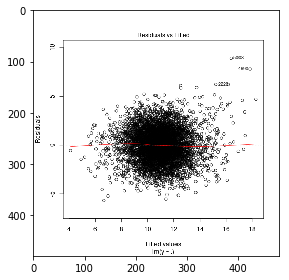

In [66]:
imshow(img);

#### Grayscale Image:

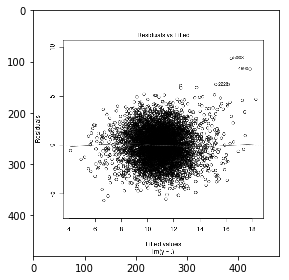

In [67]:
imshow(img_gray);

#### Rescaled Image:

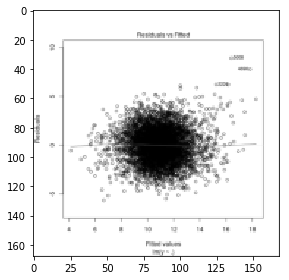

In [68]:
imshow(img_scale);

You can see our image has lost a fair amount of quality, but still contains all the same important information as the original and has been reduced in size by over 95%. This will be important, as we have 40k images to train this model on. 

In [69]:
print("Original has {n} voxels {d}".format(n=functools.reduce(lambda a,b : a*b, img.shape), d=repr(img.shape)))
print("Reduced has {n} voxels {d}".format(n=functools.reduce(lambda a,b : a*b, img_scale.shape), d=repr(img_scale.shape)))

Original has 691200 voxels (480, 480, 3)
Reduced has 28224 voxels (168, 168)


## Creating A Training Set

We've got a lot of data to process, so we'll need to write a function to convert all those images to individual numpy arrays, and also get an array that contains our response classification. Since I wrote process to simulate all this data to output a csv with file paths and classifications, this part is pretty easy. 

In [7]:
meta_data = pd.read_csv('data/control_file.csv')
meta_data.head()

,type,id,n,n_predictors,n_controls,filename
0,none,1,5426,3,2,data/png/none_0000001.png
1,none,2,588,3,4,data/png/none_0000002.png
2,none,3,7519,4,3,data/png/none_0000003.png
3,none,4,3831,4,3,data/png/none_0000004.png
4,none,5,6888,4,3,data/png/none_0000005.png


In [70]:
print(meta_data['type'].value_counts())

none       30000
ceiling    10000
biased     10000
outlier    10000
Name: type, dtype: int64


We'll need dummy encoded variables for the "type" class. 

In [31]:
dummies = pd.get_dummies(meta_data['type'], prefix='d')
meta_data = pd.concat([meta_data, dummies], axis=1)

### Preprocessing all files

Since processing all 60k files will take a while, We'll want to do it once and save the data so I can use it later. 

``` python
from multiprocessing import Pool
import os

def process_image(path):
    img = imread(path)
    img_gray = color.rgb2gray(img)
    img_scale = rescale(img_gray, .35, anti_aliasing=True)
    return img_scale

def process_save_image(file):
    path, name = os.path.split(file)
    img = process_image(path)
    imsave(os.path.join(path, '../png_redux', name), img)

p = Pool(3)
p.map(process_save_image, meta_data['filename'].tolist())
```

### Image to Numpy array

We now have out smaller images, but we need those to be numpy arrays and we want that data linked up to our meta data. Scikit image and pandas make that easy. 

In [8]:
def img_reader(file):
    path, name = os.path.split(file)
    newpath = os.path.join(path, '../png_redux', name)
    img = imread(newpath)
    return img

In [12]:
img_series = meta_data['filename'].swifter.apply(img_reader)
img_mat = np.stack(img_series.values)

1min 27s ± 1.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Training a Model

We'll just train a simple model here and not dive into evaluating how well it performed too much. Future posts will cover that. 

In [26]:
# load our sklearn dependencies
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [33]:
# create our split - set shuffle to True, since the data are random in the DataFame
train, test = train_test_split(meta_data, shuffle=True, test_size=0.2)

In [34]:
# we can use the index from train and test to pull the correct elements from 
# the matrix of image data
train_x = img_mat[train.index]
test_x = img_mat[test.index]
train_y = train['d_none'].values
test_y = test['d_none'].values

In [43]:
# reshape X to be 2d rather than 3d - sklearn expects our X matriz to have only 2 dimesnsions
train_x1 = np.reshape(train_x, (len(train_x), -1))
test_x1 = np.reshape(test_x, (len(test_y), -1))

With our numpy array in 2 dimensions, we can train our neural network. I've accepted all the defaults here because we'll go into improving accuracy in later posts--this will just serve as a benchmark. 

In [45]:
mod = MLPClassifier() # accepting all defaults here
mod.fit(train_x1, train_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

With our model trained we can see what our accuracy is on our training sample and our testing sample. 

In [55]:
print("Training Accuracy: {:.2%}".format(mod.score(train_x1, train_y)))
print("Training Accuracy: {:.2%}".format(mod.score(test_x1, test_y)))

Training Accuracy: 50.05%
Training Accuracy: 49.81%


Looks like our model is performing at chance. Might be that we need to do some more work with pre-processing, maybe resolution of the images is too low. We also didn't do any model tuning--there are many hyperparameters to tune here, and the defaults are unlikely to be even close to what we need for better results. This neural network algorithm is also not ideal for this task--we could utilize algorithms that perform better on images--specifically convolutional neural networks. 

And finally, once we get our model performing well and finding signal, we'll want to make sure it's trained to penalize false negatives more than false positives, since in this task, missing a case that should be caught is much much worse than identifying a case that is fine. 

All this in future posts. 